# Areal data modelling

## Areal data

In spatial statistics, areal data refers to data that are aggregated or summarized within predefined geographic areas or regions, such as census tracts, zip code areas, counties, or administrative districts. Unlike point-referenced data, which represent individual locations with specific coordinates, areal data are associated with spatial units that cover an area on the map.

Areal data are commonly used in spatial statistics since this is often the level at which data are available, and, at the same time, modelling at areal level is useful since this is the level at which public policy decisions are typically made.

In [2]:
#!pip install geopandas

import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from shapely.geometry import Polygon

import numpy as np

import networkx as nx

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


## Geopandas

Before we start looking at statististical models of areal data, let us get familiar with the `geopandas` package.

`geopandas` is a Python library that provides convenient, unified access to the functionalities of the `pandas` library and additional spatial data manipulation tools. It is built upon the capabilities of pandas, allowing for easy manipulation, analysis, and visualization of geospatial data.

Here's a brief tutorial to get you started with GeoPandas:

### Installation

First, you need to install GeoPandas along with its dependencies. You can install GeoPandas using pip, a Python package manager, by executing the following command in your terminal or command prompt:

`!pip install geopandas`

### Importing

Once GeoPandas is installed, you can import it in your Python script or Jupyter Notebook:

`import geopandas as gpd`

### Reading Spatial Data

GeoPandas can read various spatial data formats such as shapefiles, GeoJSON, and GeoPackage. You can read spatial data using the read_file() function:

In [3]:
# Reading a shapefile

# you can try the command below or download the data manually
# !wget -O south-africa.geojson https://github.com/codeforgermany/click_that_hood/blob/main/public/data/south-africa.geojson

gdf_sa = gpd.read_file('data/south-africa.geojson')


### Exploring Data

GeoPandas extends the capabilities of pandas DataFrames to work with spatial data. You can use familiar pandas methods to explore and manipulate GeoDataFrames:

In [4]:
gdf_sa.head()

,name,cartodb_id,created_at,updated_at,geometry
0,Alfred Nzo District,1,2015-05-21 14:28:26+00:00,2015-05-21 14:28:26+00:00,"MULTIPOLYGON (((28.20686 -30.29096, 28.20691 -..."
1,Amajuba District,2,2015-05-21 14:28:26+00:00,2015-05-21 14:28:26+00:00,"MULTIPOLYGON (((29.61686 -28.04684, 29.62217 -..."
2,Amathole District,3,2015-05-21 14:28:26+00:00,2015-05-21 14:28:26+00:00,"MULTIPOLYGON (((25.88731 -32.48680, 25.89398 -..."
3,Bojanala Platinum District,4,2015-05-21 14:28:26+00:00,2015-05-21 14:28:26+00:00,"MULTIPOLYGON (((26.38498 -25.05934, 26.41811 -..."
4,Buffalo City Metropolitan,5,2015-05-21 14:28:26+00:00,2015-05-21 14:28:26+00:00,"MULTIPOLYGON (((27.15761 -32.83846, 27.15778 -..."


In [5]:
# Displaying the first few rows of the GeoDataFrame
print(gdf_sa.head())

# Summary statistics
print(gdf_sa.describe())

# Checking column names
print(gdf_sa.columns)

# how many rows?
print(gdf_sa.shape)


                         name  cartodb_id                created_at  \
0         Alfred Nzo District           1 2015-05-21 14:28:26+00:00   
1            Amajuba District           2 2015-05-21 14:28:26+00:00   
2           Amathole District           3 2015-05-21 14:28:26+00:00   
3  Bojanala Platinum District           4 2015-05-21 14:28:26+00:00   
4   Buffalo City Metropolitan           5 2015-05-21 14:28:26+00:00   

                 updated_at                                           geometry  
0 2015-05-21 14:28:26+00:00  MULTIPOLYGON (((28.20686 -30.29096, 28.20691 -...  
1 2015-05-21 14:28:26+00:00  MULTIPOLYGON (((29.61686 -28.04684, 29.62217 -...  
2 2015-05-21 14:28:26+00:00  MULTIPOLYGON (((25.88731 -32.48680, 25.89398 -...  
3 2015-05-21 14:28:26+00:00  MULTIPOLYGON (((26.38498 -25.05934, 26.41811 -...  
4 2015-05-21 14:28:26+00:00  MULTIPOLYGON (((27.15761 -32.83846, 27.15778 -...  
       cartodb_id
count   52.000000
mean    26.500000
std     15.154757
min      1.0000

### Plot the shapefile

We could plot just the boundaries, or values attributed to each area.

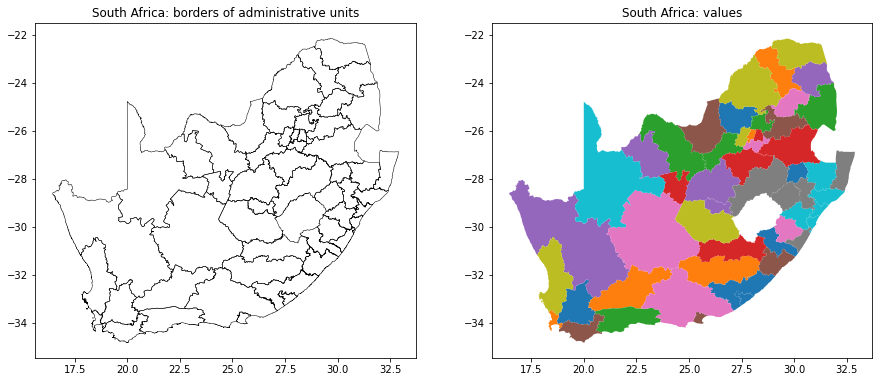

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

# Extract the boundary geometries
boundary_gdf = gdf_sa.boundary

# Plot the boundary geometries
boundary_gdf.plot(ax=ax[0], color='black', lw=0.5)
ax[0].set_title('South Africa: borders of administrative units')

gdf_sa.plot(column='name', ax=ax[1])
ax[1].set_title('South Africa: values')

plt.show()



### Saving Data

You can save GeoDataFrames to various spatial data formats using `the to_file()` method:

`gdf.to_file('path/to/output.shp')`

### Create data manually

If required, we can also create a geopandas data frame manually:

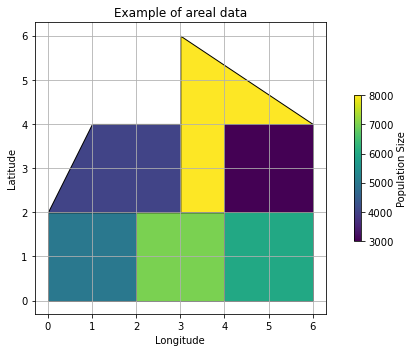

In [7]:
# Create a GeoDataFrame with administrative boundaries (made-up data for illustration)
data = {'geometry': [Polygon([(0, 0), (0, 2), (2, 2), (2, 0)]),  # Polygon 1
                     Polygon([(2, 0), (2, 2), (4, 2), (4, 0)]),  # Polygon 2
                     Polygon([(0, 2), (1, 4), (3, 4), (3, 2)]),  # Polygon 3
                     Polygon([(3, 2), (3, 6), (6, 4), (5, 2)]),  # Polygon 4
                     Polygon([(4, 0), (4, 2), (6, 2), (6, 0)]),  # Polygon 5
                     Polygon([(4, 2), (4, 4), (6, 4), (6, 2)])],  # Polygon 6
        'Name': ['Admin District 1', 'Admin District 2', 'Admin District 3',
                 'Admin District 4', 'Admin District 5', 'Admin District 6'],  # Names of admin districts
        'Population': [5000, 7000, 4000, 8000, 6000, 3000]}  # Population counts for each admin district

gdf_toy = gpd.GeoDataFrame(data)

# Plot the administrative boundaries with population size represented by color
fig, ax = plt.subplots(figsize=(8, 5))

# Define colormap
cmap = plt.cm.viridis  # Change the colormap here
norm = Normalize(vmin=gdf_toy['Population'].min(), vmax=gdf_toy['Population'].max())
sm = ScalarMappable(norm=norm, cmap=cmap)

# Plot each administrative boundary with color based on population size
for idx, row in gdf_toy.iterrows():
    color = sm.to_rgba(row['Population'])
    gdf_toy.iloc[[idx]].plot(ax=ax, color=color, edgecolor='black')

# Add colorbar with a shorter length
cbar = plt.colorbar(sm, shrink=0.5)  # Adjust the shrink parameter to change the length of the color bar
cbar.set_label('Population Size')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Example of areal data')
plt.grid(True)
plt.tight_layout()
plt.show()


## Adjancency structure

Most models of areal data rely on the concept of adjacency matrix, i.e. a matrix $A = (a_{ij})$ with entries

$$
a_{ij} = \begin{cases}
			1, & \text{if areas } B_i \text{ and } B_j \text{ are neighbours},\\
            0, & \text{otherwise}.
		 \end{cases}
$$

The adjacency matrix must be symmetric: 

$$
A = \begin{pmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{12} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{1n} & a_{2n} & \cdots & a_{nn}
\end{pmatrix}
$$



Let us compute adjacency matrix for the toy data, as well as the South Africa example.

In [8]:
def compute_adjacency_matrix(gdf):
    num_geometries = len(gdf)
    adjacency_matrix = np.zeros((num_geometries, num_geometries), dtype=int)
    
    for idx1, geometry1 in enumerate(gdf.geometry):
        for idx2, geometry2 in enumerate(gdf.geometry):
            if idx1 != idx2:
                if geometry1.touches(geometry2):  # Check if geometries share a common boundary
                    adjacency_matrix[idx1, idx2] = 1
    
    return adjacency_matrix

def visualize_adjacency_matrix(matrix):
    plt.figure(figsize=(6, 4))
    plt.imshow(matrix, cmap='binary', origin='lower')
    plt.title('Adjacency Matrix')
    plt.xlabel('Geometry Index')
    plt.ylabel('Geometry Index')
    plt.grid(False)
    plt.show()

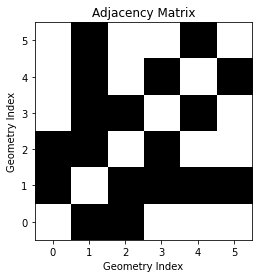

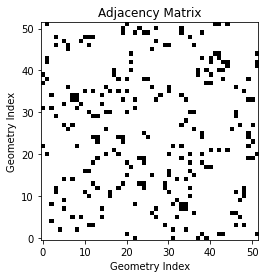

In [9]:
adjacency_matrix_toy = compute_adjacency_matrix(gdf_toy)
adjacency_matrix_sa = compute_adjacency_matrix(gdf_sa)

# Visualize the adjacency matrices
visualize_adjacency_matrix(adjacency_matrix_toy)
visualize_adjacency_matrix(adjacency_matrix_sa)

To understand adjacency, we can think about areal data as graphs with binary edges. Here each area represents a vertex in a graph, and an edge exists between vertices $i$ and $j$ if areas $B_i$ and $B_j$ share a border.

In [10]:
def adj_graph(gdf, size=(5,5), ttl='Adjacency Graph: toy data', plot=True):
    
    # create a empty graph
    nx_graph = nx.Graph()

    # add nodes with their coordinates and area names
    for idx, geometry in enumerate(gdf.geometry):
        centroid = geometry.centroid
        nx_graph.add_node(idx, pos=(centroid.x, centroid.y))

    adjacency_matrix = compute_adjacency_matrix(gdf)    

    # add edges based on adjacency
    for i, j in zip(*np.where(adjacency_matrix == 1)):
        nx_graph.add_edge(i, j)

    # visualize the graph with nodes aligned with actual locations and labeled with area names
        pos = nx.get_node_attributes(nx_graph, 'pos')

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=size)
        nx.draw(nx_graph, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=8, font_color="black", ax=ax)
        plt.title(ttl)
        plt.show()

    return nx_graph, pos

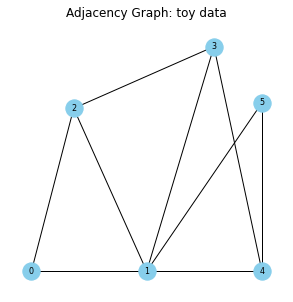

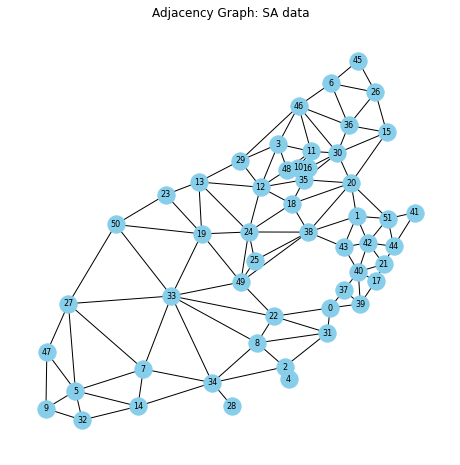

In [11]:
_,_ = adj_graph(gdf_toy)
_,_ =adj_graph(gdf_sa, size=(8,8), ttl='Adjacency Graph: SA data')

## Models of areal data

In models for areal data, the geographic units are denoted by $B_i$, and the data are typically sums or averages of variables over these blocks. To introduce spatial association, we define a neighborhood structure based on the arrangement of the blocks in the map. Once the neighborhood structure is defined, one can construct models models resembling autoregressive time series models, such as the intrinsic conditionally autoregressive model (ICAR, also called Besag) and conditionally autoregressive model (CAR).

All of the classical have the same functional form

$$
f \sim \mathcal{N}(0, Q^-)
$$

and differ in how they define the precision matrix $Q$.

### The Besag, or ICAR, model

```{margins}
Some literature deciphers 'I' in 'ICAR' as 'intrinsic', and some other as 'improper'.
```
The Besag, or ICAR (Intrinsic Conditional Autoregressive) model assumes that each location's value is conditionally dependent on the values of its neighbors. This conditional dependency is often modeled as a weighted sum of the neighboring values, where the weights are determined by the neighborhood structure. Conditional mean of the random effect $f_i$ is an average of its neighbours $\{f_j \}_{j\sim i}$ and its precision is proportional to the number of neighbours. It describes the vector of spatially varying random effects $f = (f_1, ..., f_n)^T$ using the prior $f \sim \mathcal{N}(0, Q^-).$

Here $Q^-$ denotes the generalised inverse of matrix $Q$, which, in turn, is computed as 

$$
Q = \tau R, \\
R = D - A.
$$

$D$ is a diagnoal matrix. It's $i$-th element equals the total number of neighbours of area $B_i$. Hence, $D$ can be computed from $A$:

$$
D = \begin{pmatrix}
\sum_{j=1}^n  a_{1j} & 0 & \cdots & 0 \\
0 & \sum_{j=1}^n a_{2j} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \sum_{j=1}^n a_{nj}
\end{pmatrix}.
$$

Note that  the structure matrix here can be viewed as graph Laplacian.

$R$ is a rank-defficient matrix. It is recommended, for example, to place an adidtional constraint, such sum-to-zero constraint on each non-singleton connected component:

$$
\sum_i f_i = 0.
$$



### Conditional Autoregressive Models (CAR)

Similar to ICAR, the CAR model assumes that the value of a variable in one area depends on the values of neighboring areas, with weights specified by a spatial adjacency matrix. However, it introcues an additional parameter $\alpha$, allowing to estimate the amount of spatial correlation.

The spatial random effect now is modelled as

$$f \sim \mathcal{N}(0, Q^{-1}) $$

with 

$$
Q = \tau R, \\
R = D - \alpha A, \\
0 \le \alpha < 1.
$$

If $\alpha=0$, the model consist only of i.i.d. random effects, and if $\alpha$ is close to 1, the model approaches ICAR.

Here is an artificial example of the CAR model:
 


In [21]:
def car_model(y, A):

    n = A.shape[0]
    d = jnp.diag(jnp.sum(A, axis=1))
    D = jnp.diag(d)

    b0 = numpyro.sample('b0', dist.Normal(0,1))
    tau = numpyro.sample('tau', dist.Gamma(3, 2)) 
    alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.99))

    Q_std = D - alpha*A
    Q = tau * Q_std
    
    numpyro.sample('y', dist.MultivariateNormal(b0, Q), obs=y)


# spatial data 'y' and adjacency structure 'adj'
y = np.array([1.2, 2.5, 3.8, 4.1, 5.2])  # Replace with your data

A =  np.array([[0, 1, 0, 0, 0],
               [1, 0, 1, 0, 0],
               [0, 1, 0, 1, 0],
               [0, 0, 1, 0, 1],
               [0, 0, 0, 1, 0]]) 

# Run MCMC to infer the parameters
nuts_kernel = NUTS(car_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, progress_bar=False)
mcmc.run(rng_key=jax.random.PRNGKey(0), y=y, A=A)

# Extract posterior samples
samples = mcmc.get_samples()

mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.19      0.13      0.16      0.01      0.36    722.47      1.00
        b0      2.87      0.36      2.88      2.22      3.37    531.64      1.00
       tau      1.48      0.23      1.45      1.13      1.83    638.90      1.00

Number of divergences: 0


`````{admonition} Task 28
:class: tip

- Simulate data from the CAR model using South African boundaries and neighbourhood structure (use `adjacency_matrix_sa` as `A`, and `y=None` to create simulations)
- Fit the CAR model to the data which you have simluated (make adjustments if necessary).
- Plot posterior distribution of $\alpha$, and add the true velue of $\alpha$ to this plot. What do you observe?
- Make sactter plots of $f_\text{true}$ vs $f_\text{fitted}$, and add a diagonal line to this plot. What do you observe?
`````

### The Besag-Yorg-Mollié model

The Besag, York, and Mollié (BYM) decomposes the spatial random effect $f$ into the sum of an i.i.d. component $v$ and spatiallly structured component $w$. Each of these two components has its own precision parameter $\tau_v$ and $\tau_w$, respectively:

$$
f \sim \mathcal{N}(0, \tau_v^{-1}I + \tau_w^{-1}R^-).
$$

This model provides more flexibility than the CAR formulation. 